# Housekeeping

In [8]:
if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

## Library Imports

In [32]:
# Core Libraries
import pandas as pd
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import set_config
import re

#Group splitting
from sklearn.model_selection import GroupShuffleSplit

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model Interpretability
from sklearn.metrics import mean_squared_error, r2_score
from supertree import SuperTree

# Custom Functions
from functions import set_global_seeds, MASTER_SEED
from functions import clr_transform
from functions import filter_features_by_level, feature_selection_pipeline
from functions import random_forest_benchmark
from functions import xgboost_benchmark


## Settings

In [10]:
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
print(Style.RESET_ALL)
# Set global random seeds for reproducibility
set_global_seeds(MASTER_SEED)


Global seeds set to 3004


## Encoded Data Import

In [11]:
encoded_samples = pd.read_csv("processed_data/encoded_samples.csv")

assert encoded_samples.shape == (808, 6907), "Data has the wrong shape. Check the CSV formatting."

# Data Preparation

## Train-test split 

In [12]:
feature_cols = encoded_samples.columns.difference(["sample_id", "age_group_at_sample"]) # These variables will get removed from X

X = encoded_samples[feature_cols]
Y = encoded_samples["age_group_at_sample"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=MASTER_SEED)
train_indicies, test_indicies = next(gss.split(X, Y, groups=X['family_id']))
X_train_raw = X.iloc[train_indicies]
X_test_raw = X.iloc[test_indicies]
Y_train = Y.iloc[train_indicies]
Y_test = Y.iloc[test_indicies]

assert X_train_raw.shape[1] == X_test_raw.shape[1], "Feature columns do not match between train and test sets."
assert X_train_raw.shape[0] == Y_train.shape[0] and X_test_raw.shape[0] == Y_test.shape[0], "X and Y do not have the same length."

print("Train shape:", X_train_raw.shape, "| Test shape:", X_test_raw.shape)

Train shape: (628, 6905) | Test shape: (180, 6905)


## Filtering for features

### Genus Level

In [13]:
X_train_genus_raw = filter_features_by_level(X_train_raw, max_level="Genus")
X_train_genus_filtered, _ = feature_selection_pipeline(X_train_genus_raw, Y_train)
X_train_genus = clr_transform(X_train_genus_filtered)

X_test_genus = clr_transform(X_test_raw[X_train_genus.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 137 | Removed: 2184
Best Filtering Parameters Found: {'prevalence_thresh': 0.04509105143175933, 'abundance_thresh': 7.118223965487462e-05, 'variance_thresh': 8.233700028555275e-06, 'corr_thresh': 0.8327854762343401}


### Family Level

In [7]:
X_train_family_raw = filter_features_by_level(X_train_raw, max_level="Family")
X_train_family_filtered, _ = feature_selection_pipeline(X_train_family_raw, Y_train)
X_train_family = clr_transform(X_train_family_filtered)

X_test_family = clr_transform(X_test_raw[X_train_family.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 72 | Removed: 1032
Best Filtering Parameters Found: {'prevalence_thresh': 0.04649984650483863, 'abundance_thresh': 7.208959516357094e-05, 'variance_thresh': 1.3031202975530604e-05, 'corr_thresh': 0.9980291670788177}


### Order Level

In [14]:
X_train_order_raw = filter_features_by_level(X_train_raw, max_level="Order")
X_train_order_filtered, _ = feature_selection_pipeline(X_train_order_raw, Y_train)
X_train_order = clr_transform(X_train_order_filtered)

X_test_order = clr_transform(X_test_raw[X_train_order.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 41 | Removed: 658
Best Filtering Parameters Found: {'prevalence_thresh': 0.06029707108067236, 'abundance_thresh': 0.00016156495587251984, 'variance_thresh': 1.6831941433212053e-05, 'corr_thresh': 0.9953116476354948}


### Class Level

In [15]:
X_train_class_raw = filter_features_by_level(X_train_raw, max_level="Class")
X_train_class_filtered, _ = feature_selection_pipeline(X_train_class_raw, Y_train)
X_train_class = clr_transform(X_train_class_filtered)

X_test_class = clr_transform(X_test_raw[X_train_class.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 25 | Removed: 327
Best Filtering Parameters Found: {'prevalence_thresh': 0.05279323241850655, 'abundance_thresh': 0.0001195298495896124, 'variance_thresh': 1.0620963165538587e-05, 'corr_thresh': 0.9105642456778713}


### Phylum Level

In [16]:
X_train_phylum_raw = filter_features_by_level(X_train_raw, max_level="Phylum")
X_train_phylum_filtered, _ = feature_selection_pipeline(X_train_phylum_raw, Y_train)
X_train_phylum = clr_transform(X_train_phylum_filtered)

X_test_phylum = clr_transform(X_test_raw[X_train_phylum.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 11 | Removed: 15
Best Filtering Parameters Found: {'prevalence_thresh': 0.024044158655845093, 'abundance_thresh': 4.6835706068890456e-05, 'variance_thresh': 1.0165277772556985e-05, 'corr_thresh': 0.8697559814095198}


### Species Level

In [17]:
X_train_species_raw = filter_features_by_level(X_train_raw, max_level="Species")
X_train_species_filtered, _ = feature_selection_pipeline(X_train_species_raw, Y_train)
X_train_species = clr_transform(X_train_species_filtered)

X_test_species = clr_transform(X_test_raw[X_train_species.columns])

--- Running K-Fold Optimization (30 iterations) ---
Done. Kept: 242 | Removed: 4290
Best Filtering Parameters Found: {'prevalence_thresh': 0.05936290854604697, 'abundance_thresh': 6.534489821899884e-05, 'variance_thresh': 1.3559489052656692e-05, 'corr_thresh': 0.8454384173767983}


## Shape of Data per Level

In [18]:
print(f"Genus Level: {X_train_genus.shape[1]} features | Family Level: {X_train_family.shape[1]} features | Order Level: {X_train_order.shape[1]} features | Class Level: {X_train_class.shape[1]} | Phylum Level: {X_train_phylum.shape[1]} | Species Level: {X_train_species.shape[1]}")

Genus Level: 137 features | Family Level: 72 features | Order Level: 41 features | Class Level: 25 | Phylum Level: 11 | Species Level: 242


# Models Training

## Initialise model results tracking

In [19]:
model_results = []
print("Model results tracking initialized")

Model results tracking initialized


## Random Forest Regressor on Genus

### Base Model

In [20]:
rf_base = RandomForestRegressor(
    random_state=MASTER_SEED,
    n_jobs=-1,
    oob_score=True
)

rf_base.fit(X_train_genus, Y_train)
yhat_rf = rf_base.predict(X_test_genus)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_rf):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_rf)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_rf):.3f}")


Mean Squared Error: 4540.724
Best CV RMSE: 67.385
R2 Score: 0.757


### Search for the best model

In [21]:
rf_results = random_forest_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    cv = 10,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {rf_results.best_params}")

Initializing Random Forest Engine: Genus Level
Fitting 10 folds for each of 20 candidates, totalling 200 fits

Genus Level RF Complete (38.2s) | R2: 0.753

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': 10}


In [22]:
# Track Random Forest results
model_results.append({
    'model': 'Random Forest',
    'rmse': rf_results.rmse,
    'r2': rf_results.r2,
    'best_params': rf_results.best_params,
})

In [23]:
print(f"Mean Squared Error: {rf_results.rmse**2:.3f}") # Squared because rmse is sqrt(mse)
print(f"Best CV RMSE: {rf_results.rmse:.3f}")
print(f"R2 Score: {rf_results.r2:.3f}")

best_rf_model = rf_results.model
yhat = rf_results.model.predict(X_test_genus)

Mean Squared Error: 4611.194
Best CV RMSE: 67.906
R2 Score: 0.753


### Results Visualisation

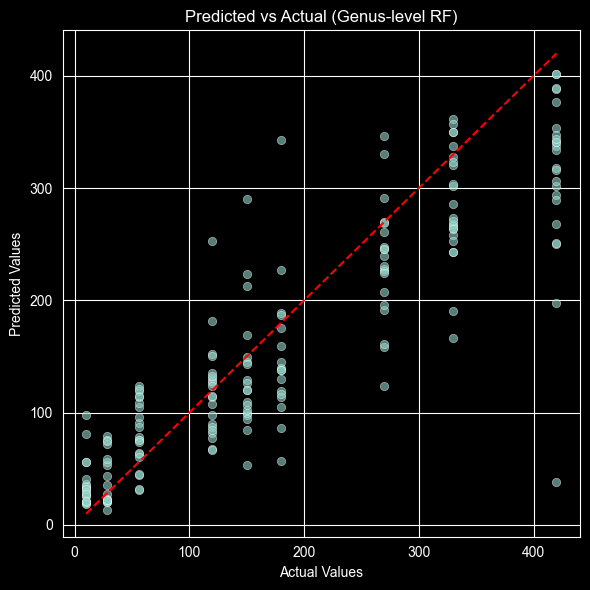

In [24]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

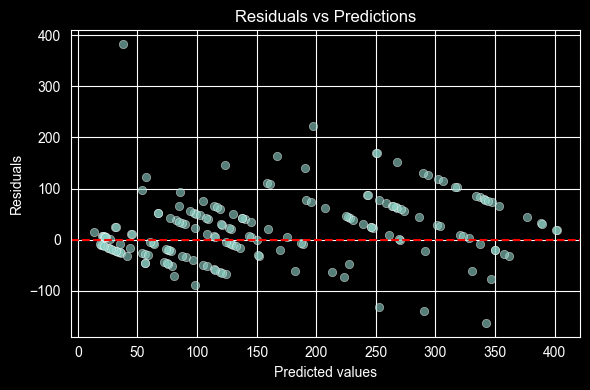

In [25]:
residuals = Y_test - yhat

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

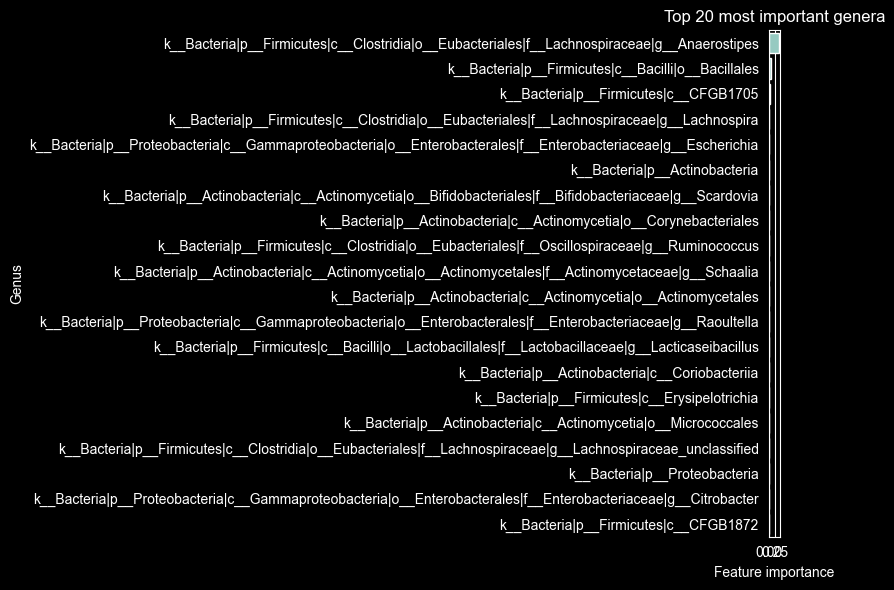

In [26]:
importances = pd.Series(
    best_rf_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()

In [27]:
st = SuperTree(
    best_rf_model,
    X_train_genus,
    Y_train
)

st.show_tree(which_tree=0)

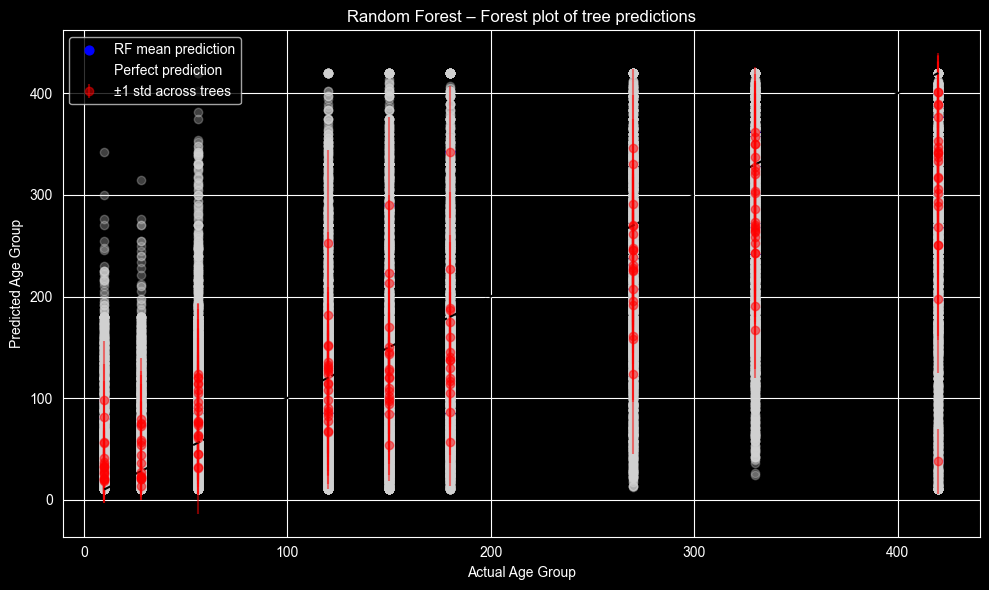

In [28]:
# get predictions from each tree on the test set
all_tree_preds = np.array([tree.predict(X_test_genus) for tree in best_rf_model.estimators_])

# compute the mean prediction (Random Forest final prediction)
rf_pred = all_tree_preds.mean(axis=0)

# compute standard deviation per sample (uncertainty)
rf_std = all_tree_preds.std(axis=0)

plt.figure(figsize=(10,6))

# plot all tree predictions (semi-transparent lines)
for i in range(all_tree_preds.shape[0]):
    plt.plot(Y_test.values, all_tree_preds[i], 'o', color='lightgray', alpha=0.3)

# plot Random Forest mean prediction
plt.scatter(Y_test, rf_pred, color='blue', label='RF mean prediction', s=40)

plt.errorbar(Y_test, rf_pred, yerr=rf_std, fmt='o', color='red', alpha=0.5, label='±1 std across trees')

plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Age Group")
plt.ylabel("Predicted Age Group")
plt.title("Random Forest – Forest plot of tree predictions")
plt.legend()
plt.tight_layout()
plt.show()


## XGBoost

In [31]:
# Base model
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=MASTER_SEED,
    n_jobs=-1
)

X_train_clean = X_train_genus.copy()
X_train_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_train_clean.columns]
X_test_clean = X_test_genus.copy()
X_test_clean.columns = [re.sub('[^A-Za-z0-9_]+', '', str(col)) for col in X_test_clean.columns]


xgb_base.fit(X_train_clean, Y_train)
yhat_xgb = xgb_base.predict(X_test_clean)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_xgb):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_xgb)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_xgb):.3f}")

Mean Squared Error: 5362.218
Best CV RMSE: 73.227
R2 Score: 0.713


### Best XGBoost Parameters Search

In [33]:
xgboost_results = xgboost_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    label="Genus Level"
)
print(f"Best hyperparameters: {xgboost_results.best_params}")

Initializing XGBoost Engine: Genus Level
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Genus Level Complete (50.4s) | R2: 0.765
Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.2}


In [34]:
# Track XGBoost results
model_results.append({
    'model': 'XGBoost',
    'rmse': xgboost_results.rmse,
    'r2': xgboost_results.r2,
    'best_params': xgboost_results.best_params,
})
